In [4]:
# Import statements
import pandas as pd




In [5]:
# Loading in preproccessed data
PATH = "/content/drive/My Drive/Data/"

# create dataframes and keep only necessary features to join dataframes
data = pd.read_csv(PATH + "preproccessed_data.csv", lineterminator='\n')

data

,title,text,label
0,muslims busted stole millions gov ’ benefits,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1
2,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1
3,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1
4,fantastic trumps 7 point plan reform healthcar...,email healthcare reform make america great sin...,1
...,...,...,...
29449,process analytical instruments market – techna...,technavio published new report global process ...,0
29450,travel deals get 1200 air credit two apt cookt...,apt offering savings new cape york outback wil...,0
29451,taiwanese recyclers belief waste simply mispla...,taipei taiwan sept 8 2015 prnewswire recent ye...,0
29452,season curtain raiser ideal way honour john,blackburn sunday league john haydock memorial ...,0


https://realpython.com/python-keras-text-classification/

In [6]:
from sklearn.model_selection import train_test_split

text = data['text'].values
label = data['label'].values

text_train, text_test, y_train, y_test = train_test_split(text, label, test_size=0.25, random_state=1000)

print(text_train[0])

also stories click phrases see list subjects places carson city nevada — amount taxable sales nevada jumped 8 percent july compared month year ago nevada department taxation reported tuesday 43 billion taxable sales nevada july nearly 337 million taxes collected sales 85 million went state general fund general fund sales tax revenue coming slightly higher economists predicted would made economic forum forecast may sectors showing big gains included auto parts dealers sales 14 percent restaurant bar sales 9 percent food beverage store sales 10 percent


In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(text_train[2])
print(X_train[2])

firearms panics happen variety things like acts domestic terrorism mass shootings democrats getting elected office though may worry years nd amendment enthusiast donald trumps decisive victory last night lets cover bases talk panic future democrats electedwhat panic ammo firearms panic people go buy items worried soon illegal buy sell items maybe already americans still believe ex post facto laws part constitutionadding panic speculators buy retailers roundly shamed raise prices resell privately much higher levels legal certainly isnt ethical decent thing folks deserve shamed mocked every opportunitylastly gun stores sites inventory handle flex buying demand manufacturer artificially contrived panic creates real scarcity corrected panic running steam everyone buys consider enough natural undercutting resets price back lower levelssome prices never return long rifle ammunition still totally recovered damage old brock islamic shock obama multiyear championship best firearms salesman ever

In [8]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  12  838 1375   57  502 4517 1134   77 2725    7  972  884 2725 4106
  578   59  757 1253  243   29  228 2725  116  174  262 3768  392  884
 2725  757  363   82 1386 3526  884 4859   82  279   19  161  958  161
  958  884  390 1845  385 2672  691 4045 2531    9   43  264 2984 4896
   35 1189  181 3092  776 4503 1060  884 1057   59 1931 1759  884  851
   59  376 1210  884  223   59    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [18]:
from keras.models import Sequential
from keras import layers

def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Training Accuracy: 0.9754
Testing Accuracy:  0.8425


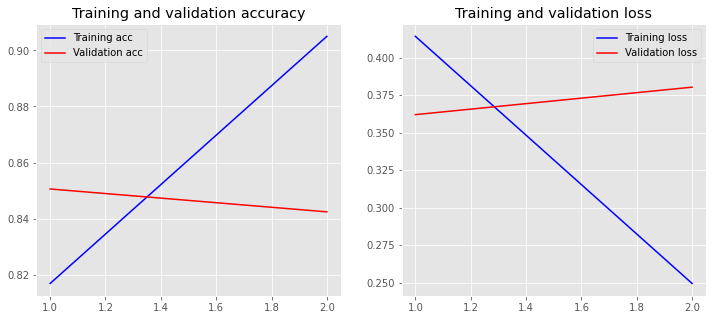

In [16]:
history = model.fit(X_train, y_train,
                    epochs = 4,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


In [19]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 4
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=10, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
with open(output_file, 'a') as f:
        s = ('Running data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
